This iPython notebook is about testing for stationarity using Slepian wavelets


## Slepian wavelets

Generally, an observed time series $X_t$ can be decomposed by applying a set of wavelet filter $h_{jl}$:

$$ W_{j,t} = \sum^{L_j - 1}_{l=0} h_{jl} X_{t-l}; \,\, t = 0, \pm 1, \ldots; \,\, j = 1,2,\ldots; \,\, L \ge 2d $$

with the wavelet coefficient, $W_{j,t}$ proportional to changes in adjacent weighted averages over an effective scale of $2^{j-1}$ time points. The wavelet variance at scale $j$ is thus associated with a timescale $\tau_j = 2^{j-1}\bar{\Delta}$.

At level $j$, the standard wavelet transform produces at level $j$ a single set of coefficients associated with the interval $[1/2^{j+1}, 1/2^j]$.

$$ W_{j,n,t} = \sum_{l=0}^{L_j -1} f_{j,n,l} X_{t-l}; \,\, n = 0, \ldots, 2^j -1; 0 \le t \le N -1$$

where  

$$ f_{j,n,l} = \sum_{k=0}^{L-1} f_{n,k} f_{j-1,n/2,l-2^{j-1}k} ; \,\, 0 \le l \le L_j -1 $$

with $f_{n,l}  = g_l$ if $n \% 4 = 0 $ or $3$, $h_l$ if $n \% 4 = 1$ or $2$ and $g_l = (-1)^{l+1}h_{L-l-1}$, $f_{1,0,l} = g_l$ and $f_{1,1,l} = h_l$.



For the packet transformation, we have

$$t = 2^{J-1} \bar{\Delta}$$

jscale is from  0 to $2^{J-1}$ ( or from 1 to $2^J$ depending on how you
define jscale). The idea is to divide the frequency range into $2^J$
equal length intervals.

Here we set J (that takes the role of max.scale) at the beginning.

For example, for a time series with 280 data points, the wavelet variance will have 8 points (maxscale = 8) and $\tau_j$ will go from $2^0 \cdot \bar{\Delta}$ to $2^7 \cdot \bar{\Delta}$.

Based on <a href="http://www.maths.bris.ac.uk/~guy/Research/papers/WavProcEWS1.pdf">this paper</a>.

In [19]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
from spectrum import dpss
import warnings
import matplotlib.pyplot as plt
from utils import clean, groupByDate
import os

warnings.simplefilter("ignore", RuntimeWarning) 

def qmatrix(c, J, j0, mu, mesh, K = 1):
  # Q matrix for Slepian wavelet
  fl = j0 / 2**(J + 1) / mu
  fr = (j0 + 1.) / 2**(J  + 1) / mu
  mm = (2 ** J) * c
  mat = np.repeat(mesh, mm).reshape(mm, mm) - np.repeat(mesh, mm).reshape(mm, mm).T
  slep = (np.sin(2. * np.pi * mat * fr) - np.sin(2. * np.pi * mat * fl)) / (np.pi * mat)
  np.fill_diagonal(slep, 2. * (fr - fl))
  iden = np.identity(mm) - 1./mm
  slep = np.dot(iden, np.dot(slep, iden))
  return slep


def eigenvector(c, jscale, j, mu, mesh, K = 1):
  # Largest eigenvector of Q matrix
  slep = qmatrix(c, jscale, j, mu, mesh, K = K)
  evs = la.eigh(slep)[1] # Largest eigenvector is last one (eigenvalues in ascending order)
  return evs[:, -1][::-1] # This was originally negative


def slepian(c, jscale, j, mu, mesh, K = 1):
  # Calculate Slepian wavelets directly
  evs = eigenvector(c, jscale, j, mu, mesh, K = K) 
  return evs / np.sqrt(2. ** jscale * mu)
        

def wavelet_variance(data):
  # Calculate the Slepian wavelet variance
  times, obsx, obsxerr = data
  n = len(obsx) - 2
  times = times - times[0]
  meandelta = times[n + 1] / (n + 1)
#  meandelta = np.median(np.diff(times))
  cons = 1
  maxscale = int(np.floor(np.log2(n + 2)))
  sLj = [2**(j+1) * cons for j in range(maxscale)]
  sMj = [n - sLj[j] + 1 for j in range(maxscale)]
  mu = meandelta
  dps = []
  lamplus = []
  # Calculate Slepian wavelets
  sw_var = np.zeros(maxscale)
  tau = np.zeros_like(sw_var) 
  sw_dis = np.zeros_like(sw_var)
  wc = np.empty((maxscale, n))
  fig, ax = plt.subplots(1, maxscale, figsize = (15, 3))
  ser = np.zeros([maxscale, np.max(sMj)])
  for jscale in range(maxscale):
    a, b = dpss(sMj[jscale], 3.5, 5)
    dps.append(a)
    lamplus.append(np.repeat(1, sMj[jscale]).dot(dps[jscale]))
    for tpt in range(sMj[jscale]):
      index = range(tpt + 1, tpt + sLj[jscale] + 1)
      wf = slepian(cons, jscale + 1, 1, mu, times[index], 1)
      try:
        wc[jscale, tpt] = np.dot(obsx[index], wf)
      except ValueError:
        print jscale, tpt, index, obsx[index], wf
        sys.exit(-1)
    ser[jscale, 0:sMj[jscale]] = wc[jscale, 0:sMj[jscale]] ** 2.
    ax[jscale].plot(range(sMj[jscale]), ser[jscale, 0:sMj[jscale]])
  plt.show()
  return ser
    
    
def getData(id):
  field = str(id)[:7]
  path = ''
  paths = ['/Users/mjg/Projects/quasvar/data/crts/var/%s/%s.dat' % (field, id),
           '/Users/mjg/Projects/quasvar/data/wise/lcs/%s.dat' % id,
           '/Users/mjg/Projects/quasvar/data/crts/xdqso/%s.dat' % id,
           '/Users/mjg/Projects/quasvar/data/crts/fields/%s/%s.dat' % (field, id)]
  for p in paths:
    if os.path.exists(p):
      path = p
      break
  raw = np.genfromtxt(path)
  data = groupByDate(clean(raw.T))
  return data    

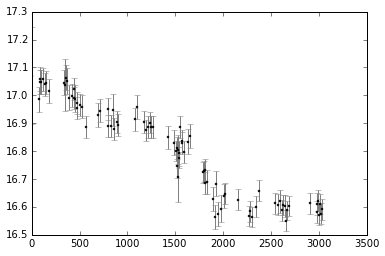

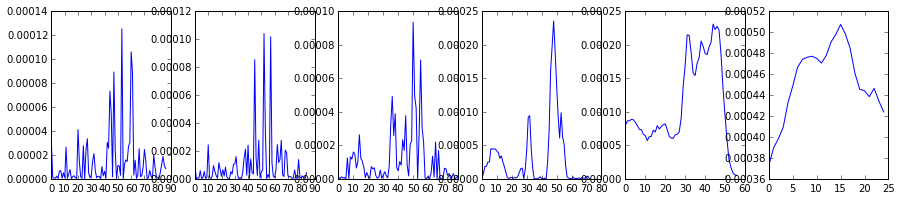

array([[  2.82862636e-05,   7.85388035e-07,   7.37647281e-07,
          4.66913655e-07,   2.24500666e-06,   2.75928983e-07,
          6.62261977e-06,   6.71660037e-06,   5.28561698e-07,
          5.00130588e-06,   9.76244829e-07,   2.65736168e-05,
          4.10155665e-07,   4.15557541e-06,   7.74873558e-06,
          2.58671697e-08,   1.73526437e-06,   2.58869124e-06,
          9.35188480e-07,   2.49987170e-07,   4.11634862e-05,
          1.44062205e-05,   1.78366615e-06,   3.18835981e-07,
          2.77090636e-05,   5.16812051e-10,   2.39396753e-05,
          3.36064482e-05,   4.77958580e-06,   9.13701494e-07,
          3.04203579e-06,   1.45829063e-05,   2.10716841e-05,
          6.81191354e-06,   9.47650322e-07,   2.03397217e-06,
          2.05576698e-06,   2.64821064e-09,   1.01989909e-05,
          2.48430547e-06,   6.26842332e-06,   6.63147721e-07,
          3.04356944e-05,   2.56234822e-05,   7.33588545e-05,
          5.44581548e-05,   1.72719399e-06,   8.93491832e-05,
        

In [20]:
id = 1101123020306
data = getData(id)
fig, ax = plt.subplots()
ax.errorbar(data[0], data[1], data[2],  fmt = '.k', ecolor = 'gray', lw = 1, ms = 4)
plt.show()
wavelet_variance(data)



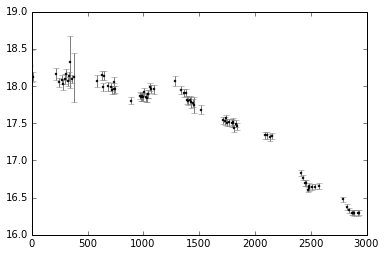

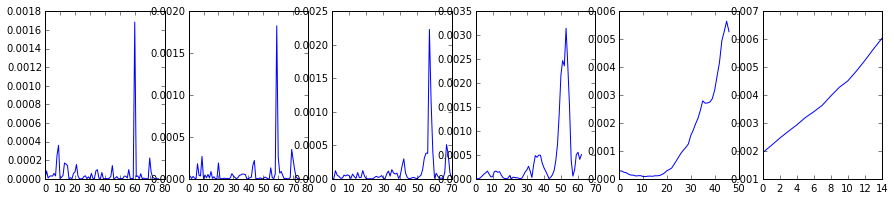

array([[  9.36604063e-06,   8.48432012e-05,   8.70139183e-06,
          2.66685684e-05,   3.18742249e-05,   2.86236632e-05,
          5.83929402e-05,   3.06314155e-05,   2.54708658e-04,
          3.60036464e-04,   4.04279169e-06,   1.53597652e-05,
          3.65593790e-05,   1.69630773e-04,   1.58323773e-04,
          1.40786639e-04,   2.96293006e-07,   1.11003950e-05,
          1.83584052e-06,   5.88902660e-05,   7.25337018e-05,
          1.53742825e-04,   3.13144878e-05,   1.21491080e-06,
          1.36127520e-07,   3.47025791e-07,   2.41669712e-05,
          3.19733166e-05,   7.82087887e-08,   2.10571224e-05,
          1.04888956e-07,   5.88258750e-05,   4.50571999e-06,
          4.92927877e-07,   8.52452054e-05,   9.84119782e-05,
          8.95163334e-06,   9.95919365e-08,   6.72366924e-05,
          1.47235002e-06,   5.87101856e-07,   2.84338443e-06,
          5.27249212e-07,   6.97193963e-06,   2.57814618e-05,
          1.42404279e-04,   4.39877416e-07,   9.19136802e-06,
        

In [21]:
id = 1135058030905
data = getData(id)
fig, ax = plt.subplots()
ax.errorbar(data[0], data[1], data[2],  fmt = '.k', ecolor = 'gray', lw = 1, ms = 4)
plt.show()
wavelet_variance(data)
